# Project on Classification of Different Species of Plants

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2gray, rgb2hsv
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import cv2
import seaborn as sns
from tqdm import tqdm
from sklearn.impute import SimpleImputer
import joblib

main_folder = r"D:/plant_species_for_ct/split_ttv_dataset_type_of_plants"
train_folder = os.path.join(main_folder,"Train_Set_Folder")
test_folder = os.path.join(main_folder,"Test_Set_Folder" )

print("Dataset paths:")
print(f"Train folder: {train_folder}")
print(f"Test folder: {test_folder}")

Dataset paths:
Train folder: D:/plant_species_for_ct/split_ttv_dataset_type_of_plants\Train_Set_Folder
Test folder: D:/plant_species_for_ct/split_ttv_dataset_type_of_plants\Test_Set_Folder


In [2]:
def extract_color_features(image):
    """Extracting color features using histograms"""
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    hist_rgb = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist_rgb = cv2.normalize(hist_rgb, hist_rgb).flatten()
    
    hist_hsv = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist_hsv = cv2.normalize(hist_hsv, hist_hsv).flatten()
    
    hist_lab = cv2.calcHist([lab], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist_lab = cv2.normalize(hist_lab, hist_lab).flatten()
    
    return np.hstack([hist_rgb, hist_hsv, hist_lab])

def extract_texture_features(image):
    """Extracting texture features using LBP and simple statistics"""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=10, range=(0, 10))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-7)
    
    texture_stats = [
        gray.mean(), gray.std(),
        np.median(gray),
        gray.max() - gray.min()
    ]
    
    return np.hstack([lbp_hist, texture_stats])

def extract_shape_features(image):
    """Extracting basic shape features"""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return np.zeros(4)
    
    cnt = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    
    if perimeter == 0:
        return np.zeros(4)
    
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    aspect_ratio = float(gray.shape[1]) / gray.shape[0]
    
    return np.array([area, perimeter, circularity, aspect_ratio])

def extract_hog_features(image):
    """Extracting HOG features"""
    gray = rgb2gray(image)
    resized_img = resize(gray, (128, 64))
    fd = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
             cells_per_block=(2, 2), channel_axis=None)
    return fd

def extract_all_features(image_path):
    try:
        image = imread(image_path)
        if image is None:
            return None
        
        image = cv2.resize(image, (256, 256))
        
        color_features = extract_color_features(image)
        texture_features = extract_texture_features(image)
        shape_features = extract_shape_features(image)
        hog_features = extract_hog_features(image)
        
        return np.hstack([color_features, texture_features, shape_features, hog_features])
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

In [3]:
def load_dataset(folder_path):
    data = []
    labels = []
    class_names = []
    failed_images = 0
    
    for class_id, class_name in enumerate(sorted(os.listdir(folder_path))):
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path):
            continue
            
        class_names.append(class_name)
        print(f"\nProcessing class: {class_name}")
        
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        for image_file in tqdm(image_files, desc="Processing images"):
            image_path = os.path.join(class_path, image_file)
            features = extract_all_features(image_path)
            
            if features is not None:
                data.append(features)
                labels.append(class_id)
            else:
                failed_images += 1
    
    if len(data) == 0:
        raise ValueError("No features were extracted - check your image paths")
    
    print(f"\nSuccessfully processed {len(data)} images")
    print(f"Failed to process {failed_images} images")
    
    return np.array(data), np.array(labels), class_names

print("\nLoading training data...")
X_train, y_train, class_names = load_dataset(train_folder)

print("\nLoading test data...")
X_test, y_test, _ = load_dataset(test_folder)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Number of classes: {len(class_names)}")


Loading training data...

Processing class: aloevera


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:37<00:00, 21.10it/s]



Processing class: banana


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:36<00:00, 22.14it/s]



Processing class: bilimbi


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:35<00:00, 22.49it/s]



Processing class: cantaloupe


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:34<00:00, 23.20it/s]



Processing class: cassava


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:36<00:00, 22.10it/s]



Processing class: coconut


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:36<00:00, 22.10it/s]



Processing class: corn


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:38<00:00, 20.75it/s]



Processing class: cucumber


Processing images: 100%|█████████████████████████████████████████████████████████████| 800/800 [00:32<00:00, 24.60it/s]



Processing class: curcuma


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:32<00:00, 24.24it/s]



Processing class: eggplant


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:32<00:00, 24.43it/s]



Processing class: galangal


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:29<00:00, 27.43it/s]



Processing class: ginger


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:30<00:00, 26.21it/s]



Processing class: guava


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:29<00:00, 27.00it/s]



Processing class: kale


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:29<00:00, 27.07it/s]



Processing class: longbeans


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:28<00:00, 28.03it/s]



Processing class: mango


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:30<00:00, 26.60it/s]



Processing class: melon


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:30<00:00, 26.44it/s]



Processing class: orange


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:35<00:00, 22.70it/s]



Processing class: paddy


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:37<00:00, 21.41it/s]



Processing class: papaya


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:40<00:00, 19.74it/s]



Processing class: peper chili


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:40<00:00, 19.59it/s]



Processing class: pineapple


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:53<00:00, 14.87it/s]



Processing class: pomelo


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:44<00:00, 18.05it/s]



Processing class: shallot


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:42<00:00, 18.87it/s]



Processing class: soybeans


Processing images: 100%|█████████████████████████████████████████████████████████████| 800/800 [00:46<00:00, 17.07it/s]



Processing class: spinach


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:42<00:00, 18.79it/s]



Processing class: sweet potatoes


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:49<00:00, 16.07it/s]



Processing class: tobacco


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:48<00:00, 16.42it/s]



Processing class: waterapple


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:43<00:00, 18.25it/s]



Processing class: watermelon


Processing images: 100%|█████████████████████████████████████████████████████████████| 799/799 [00:54<00:00, 14.78it/s]



Successfully processed 23972 images
Failed to process 0 images

Loading test data...

Processing class: aloevera


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.80it/s]



Processing class: banana


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.20it/s]



Processing class: bilimbi


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.14it/s]



Processing class: cantaloupe


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.01it/s]



Processing class: cassava


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.37it/s]



Processing class: coconut


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.26it/s]



Processing class: corn


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.41it/s]



Processing class: cucumber


Processing images: 100%|███████████████████████████████████████████████████████████████| 99/99 [00:04<00:00, 22.98it/s]



Processing class: curcuma


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.28it/s]



Processing class: eggplant


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.49it/s]



Processing class: galangal


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.78it/s]



Processing class: ginger


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.56it/s]



Processing class: guava


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.09it/s]



Processing class: kale


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.88it/s]



Processing class: longbeans


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.94it/s]



Processing class: mango


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.97it/s]



Processing class: melon


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.00it/s]



Processing class: orange


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.15it/s]



Processing class: paddy


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.70it/s]



Processing class: papaya


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.05it/s]



Processing class: peper chili


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.33it/s]



Processing class: pineapple


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.01it/s]



Processing class: pomelo


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.61it/s]



Processing class: shallot


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.38it/s]



Processing class: soybeans


Processing images: 100%|███████████████████████████████████████████████████████████████| 99/99 [00:04<00:00, 20.13it/s]



Processing class: spinach


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.79it/s]



Processing class: sweet potatoes


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.50it/s]



Processing class: tobacco


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.06it/s]



Processing class: waterapple


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.53it/s]



Processing class: watermelon


Processing images: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.58it/s]


Successfully processed 2998 images
Failed to process 0 images

Training data shape: (23972, 5334)
Test data shape: (2998, 5334)
Number of classes: 30


In [4]:
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("\nPreprocessing completed!")


Preprocessing completed!


Training model...

Training Accuracy: 0.9941
Test Accuracy: 0.9206

Classification Report:
                precision    recall  f1-score   support

      aloevera       0.88      0.85      0.86       100
        banana       0.91      0.96      0.94       100
       bilimbi       0.86      0.96      0.91       100
    cantaloupe       0.89      0.82      0.85       100
       cassava       0.87      0.96      0.91       100
       coconut       0.82      0.89      0.86       100
          corn       0.94      0.97      0.96       100
      cucumber       0.79      0.98      0.87        99
       curcuma       0.90      0.89      0.89       100
      eggplant       0.98      1.00      0.99       100
      galangal       0.96      0.95      0.95       100
        ginger       0.93      0.95      0.94       100
         guava       0.99      0.94      0.96       100
          kale       0.76      0.90      0.82       100
     longbeans       0.85      0.96      0.90       100
         man

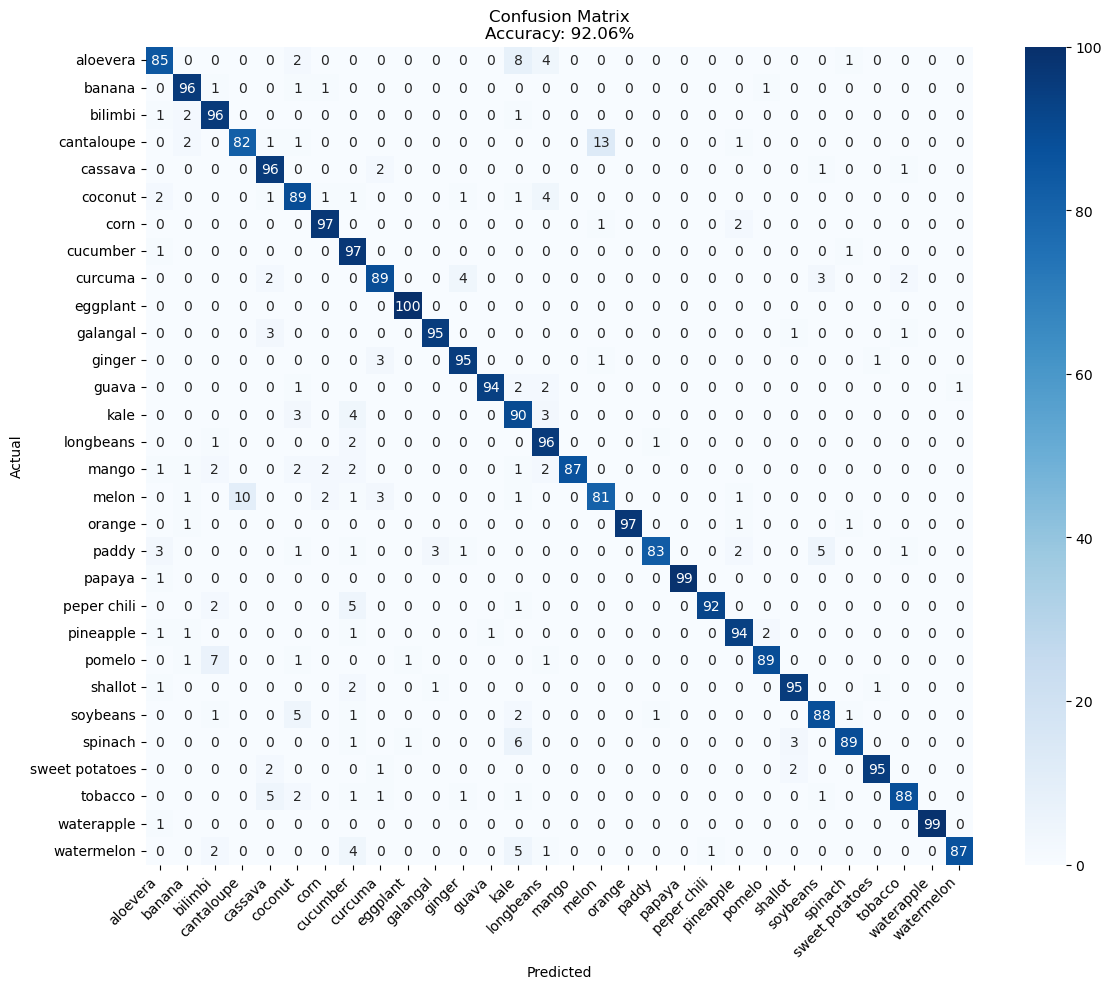

In [5]:
def train_and_evaluate(X_train, y_train, X_test, y_test, class_names):
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    
    print("Training model...")
    model.fit(X_train, y_train)
   
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    
    print(f"\nTraining Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, test_pred, target_names=class_names))
  
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_test, test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix\nAccuracy: {test_acc:.2%}', fontsize=12)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return model

model = train_and_evaluate(X_train, y_train, X_test, y_test, class_names)

In [6]:
save_dir = "D:/plant_species_for_ct/saved_models"
os.makedirs(save_dir, exist_ok=True)

joblib.dump(model, os.path.join(save_dir, 'plant_classifier.pkl'))
joblib.dump(scaler, os.path.join(save_dir, 'scaler.pkl'))
joblib.dump(imputer, os.path.join(save_dir, 'imputer.pkl'))
joblib.dump(class_names, os.path.join(save_dir, 'class_names.pkl'))

print(f"\nModel and artifacts saved to {save_dir}")


Model and artifacts saved to D:/plant_species_for_ct/saved_models


# Testing on random image

In [8]:
def predict_plant(image_path):
    try:
        features = extract_all_features(image_path)
        if features is None:
            return "Error: Could not process image"
            
        features = imputer.transform([features])
        features = scaler.transform(features)
        
        prediction = model.predict(features)
        return f"Predicted plant: {class_names[prediction[0]]}"
        
    except Exception as e:
        return f"Prediction failed: {str(e)}"

test_image = r"D:\plant_species_for_ct\split_ttv_dataset_type_of_plants\Validation_Set_Folder\guava\aug_0_95.jpg" 
print(predict_plant(test_image))

Predicted plant: guava
